# Distelbert

In [1]:
!pip install transformers[torch]

^C


In [ ]:
!pip install datasets

### Import important libraries

In [ ]:
import os
import pandas as pd
import transformers as tr
import numpy as np
from datasets import Dataset, load_metric,load_dataset
import torch
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

### Read data that contains news labeled for bias classification 

In [ ]:
hyper = pd.read_csv("https://github.com/ahmedbadawy11/NLP_Assignments/raw/main/hypertesian/bias_train.csv")
allsides_test = pd.read_csv("https://github.com/ahmedbadawy11/NLP_Assignments/raw/main/allsides_original_test.csv")
allsides_train= pd.read_csv("https://github.com/ahmedbadawy11/NLP_Assignments/raw/main/allsides_original_train.csv")

In [ ]:
hyper.shape

(100000, 6)

In [ ]:
allsides_train.shape

(35000, 6)

### Use the news article and label(bias) only

In [ ]:
allsides_train = allsides_train[["text", "bias"]]
allsides_test = allsides_test[["text", "bias"]]
hyper = hyper[["text", "bias"]]

In [ ]:
hyper.head()

,text,bias
0,US District Judge Charles Breyer today sentenc...,4
1,"Slate ""Nobody wants to read editorials,"" says ...",2
2,Maybe pragmatism isn’t enough after all. \nPre...,4
3,"ALBUQUERQUE, N.M. - He had traveled more than ...",2
4,I think it’s something we need to look at. It’...,2


### Change the label for hyperpartisan data from 5 labels to 3 labels (right - center - left)


In [ ]:
mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}
hyper['bias'] = hyper['bias'].replace(mapping)
hyper.head()

<ipython-input-11-9e7f4ae54418>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hyper['bias'] = hyper['bias'].replace(mapping)


,text,bias
0,US District Judge Charles Breyer today sentenc...,2
1,"Slate ""Nobody wants to read editorials,"" says ...",1
2,Maybe pragmatism isn’t enough after all. \nPre...,2
3,"ALBUQUERQUE, N.M. - He had traveled more than ...",1
4,I think it’s something we need to look at. It’...,1


### Use 90k rows from hyper data for training and 10k for test

In [ ]:
from sklearn.model_selection import train_test_split
hyper_train, hyper_test= train_test_split(
    hyper,
    train_size=90000,
    stratify=hyper["bias"],
    random_state=42
)

### Change number-encoded label to categorical

In [ ]:
replace_values = {0: 'Right', 1: 'Center', 2: 'Left'}

hyper_train['bias'] = hyper_train['bias'].replace(replace_values)
hyper_test['bias'] = hyper_test['bias'].replace(replace_values)

allsides_train['bias'] = allsides_train['bias'].replace(replace_values)
allsides_test['bias'] = allsides_test['bias'].replace(replace_values)

### Merge all training datasets to have 125k for training our model


In [ ]:
bias_train = pd.concat([hyper_train, allsides_train], ignore_index=True)

In [ ]:
bias_train.bias.value_counts()

Left      45590
Right     41771
Center    37639
Name: bias, dtype: int64

### Remove duplicated rows


In [ ]:
bias_train.duplicated().sum()

1365

### Remove duplicates in the 'text' column


In [ ]:
bias_train = bias_train.drop_duplicates(subset=["text"])
bias_train.drop_duplicates(inplace=True)

### Define `MODEL_NAME` as 'distilbert-base-uncased' and initialize a tokenizer using the `AutoTokenizer` class from the transformers library for the specified model.


In [ ]:
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = tr.AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Local Directory to save our model

In [ ]:
local_training_root = "Bias/"
checkpoint_name = "Combined_trainer_distilbert-base-uncased"
local_checkpoint_path = os.path.join(local_training_root, checkpoint_name)

### Configure training arguments, specifying parameters such as output directory, training epochs, batch size, learning rate, and evaluation strategy, using the transformers library.


In [ ]:
training_args = tr.TrainingArguments(
    output_dir=local_checkpoint_path,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    learning_rate=2e-05,
    weight_decay=0.01,
    evaluation_strategy="steps",
    logging_dir='./logs',
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to=["tensorboard"],
    seed=42,
)

### Load a pre-trained DistilBERT model for sequence classification with 3 labels using the specified model name.


In [ ]:
distilbert = tr.AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


###  Create a function `compute_metrics` to compute evaluation metrics (Accuracy)


In [ ]:
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-26-96ec15a93e44>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


### Convert our dataframe to dataset

In [ ]:
dataset = Dataset.from_pandas(bias_train)
dataset = dataset.train_test_split(test_size=0.1)

### Encode our labels to be used for fine-tuning


In [ ]:
label_map = {"Right": 0, "Center": 1,"Left":2}
def encode_labels(example):
    example['bias'] = label_map[example['bias']]
    return example

dataset["train"] = dataset["train"].map(encode_labels)
dataset["test"] = dataset["test"].map(encode_labels)

Map:   0%|          | 0/111271 [00:00<?, ? examples/s]

Map:   0%|          | 0/12364 [00:00<?, ? examples/s]

### Define a function `to_tokens` to tokenizes the "text" column using the tokenizer


In [ ]:
def to_tokens(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

In [ ]:
tokenized_dataset = dataset.map(to_tokens, remove_columns=["text"])

Map:   0%|          | 0/111271 [00:00<?, ? examples/s]

Map:   0%|          | 0/12364 [00:00<?, ? examples/s]

### Replace "bias" with "labels" to enhance model understanding


In [ ]:
tokenized_dataset["train"] = tokenized_dataset["train"].rename_column("bias", "labels")
tokenized_dataset["test"] = tokenized_dataset["test"].rename_column("bias", "labels")

### Fine-tune the DistilBERT model on our data


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=distilbert,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
500,0.703600,0.543861,0.771676
1000,0.509500,0.484699,0.786153
1500,0.449200,0.411560,0.825785
2000,0.413900,0.392229,0.837917
2500,0.397300,0.370990,0.846652
3000,0.381000,0.360685,0.852071
3500,0.363900,0.344787,0.859269
4000,0.353000,0.346145,0.861210
4500,0.345400,0.332781,0.864283
5000,0.338400,0.343009,0.860320


TrainOutput(global_step=6955, training_loss=0.39640654749702325, metrics={'train_runtime': 2065.1334, 'train_samples_per_second': 53.881, 'train_steps_per_second': 3.368, 'total_flos': 1.4740042778901504e+16, 'train_loss': 0.39640654749702325, 'epoch': 1.0})

### Save the model 

In [ ]:
trainer.save_model()
trainer.save_state()
checkpoint_name = "Combined_trainer_distilbert-base-uncased"
final_model_path = f"/content/drive/MyDrive/Bias/Albert/{checkpoint_name}"
trainer.save_model(output_dir=final_model_path)

### Get the model after fine-tuning to test it 

In [ ]:
fine_tuned_model = tr.AutoModelForSequenceClassification.from_pretrained(final_model_path)

### Function for evaluate our model with any dataframe 

In [ ]:
def evaluate_data(df):
    predictions = []

    for index, row in df.iterrows():
        text = row["text"]
        news_report = [text]

        inputs = tokenizer(
            news_report, return_tensors="pt", truncation=True, padding=True
        )
        with torch.no_grad():
            outputs = fine_tuned_model(**inputs)
        pred = torch.argmax(outputs.logits, dim=-1)

        classification = int(pred)
        predictions.append(classification)

    df["predictions"] = predictions

    classification_rep = classification_report(df["bias"].tolist(), df["predictions"])
    print("Classification Report:")
    print(classification_rep)

    accuracy = accuracy_score(df["bias"], df["predictions"])

    return accuracy

### Function to sample test examples from the dataframe with an equal number of rows for each label

In [ ]:
def test_sample(dataframe, label="bias", sample_size=400):
    return dataframe.groupby(label, group_keys=False).apply(lambda x: x.sample(sample_size))


In [ ]:
replace_values = {"Right": 0, "Center": 1,"Left":2}

### Test on hyperpartisan data


In [ ]:
test_hyper=  test_sample(hyper_test)
test_hyper['bias'] = test_hyper['bias'].replace(replace_values)
accuracy_hyper_test = evaluate_data(test_hyper)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       400
           1       0.99      0.98      0.99       400
           2       0.87      0.96      0.91       400

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.94      0.94      0.94      1200



### Test on allsides data


In [ ]:
allsides_val=test_sample(allsides_test)
allsides_val['bias'] = allsides_val['bias'].replace(replace_values)
accuracy_allsides_test = evaluate_data(allsides_val)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       400
           1       0.86      0.71      0.78       400
           2       0.66      0.81      0.73       400

    accuracy                           0.75      1200
   macro avg       0.76      0.75      0.75      1200
weighted avg       0.76      0.75      0.75      1200



### Plot the accuracy for each dataset


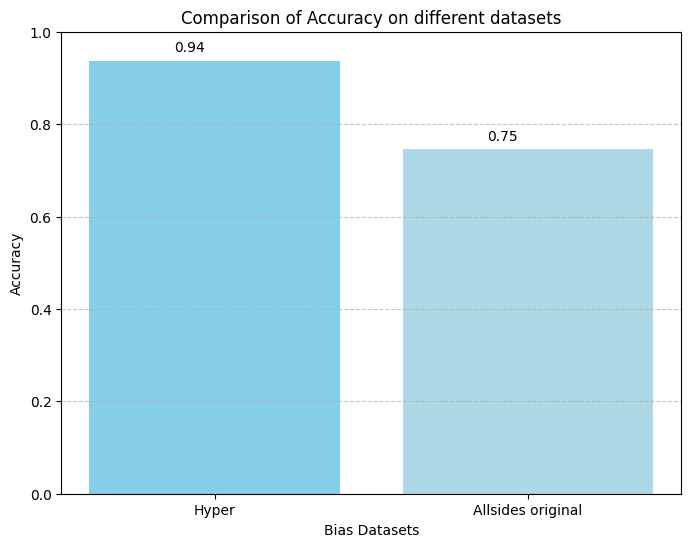

In [ ]:
values = [accuracy_hyper_test,accuracy_allsides_test]
names = [ 'Hyper','Allsides original']
colors = ['skyblue', 'lightblue']

plt.figure(figsize=(8, 6))
bars = plt.bar(names, values, color=colors)

plt.xlabel('Bias Datasets')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy on different datasets')

# Add values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.08, bar.get_height() + 0.02, f'{value:.2f}', ha='center')

plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()
